# Competitiveness in Georgia

This notebook explores the baseline of competitive districts in Georgia in our neutral ensembles and how the number of competitives seats coralates with various partisanship metrics.

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
import pickle
import pandas as pd

In [4]:
## Load ensemble results
cong = np.load("data/GA_congress_100000.p")
sen = np.load("data/GA_state_senate_100000.p")
house = np.load("/cluster/tufts/mggg/jmatth03/Georgia/GA_state_house_100000.p")

In [ ]:
## Pull in graph and set up enacted partitions

In [6]:
with open("GA_graph_3_7_1.p", "rb") as f:
    graph = pickle.load(f)

In [7]:
elections = [Election("SEN16", {"Dem": "SEN16D", "Rep": "SEN16R"}),
             Election("PRES16", {"Dem": "PRES16D", "Rep": "PRES16R"})]


ga_updaters = {"population" : Tally("TOTPOP", alias="population"),
               "cut_edges": cut_edges,
               "VAP": Tally("VAP"),
               "WVAP": Tally("WVAP"),
               "HVAP": Tally("HVAP"),
               "BVAP": Tally("BVAP"),
               "HVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["HVAP"].items()},
               "WVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["WVAP"].items()},
               "BVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["BVAP"].items()},
               "BHVAP_perc": lambda p: {k: ((p["HVAP"][k] + p["BVAP"][k]) / v) for k, v in p["VAP"].items()},}

election_updaters = {election.name: election for election in elections}
ga_updaters.update(election_updaters)

In [8]:
sen_part = Partition(graph, assignment="SENDIST", updaters=ga_updaters)
cong_part = Partition(graph, assignment="CONDIST", updaters=ga_updaters)

## Ensemble Stats

In [10]:
def competitive_seats(e, results):
    compet = list(map(np.sum, np.logical_and(results["results_{}".format(e.lower())] > 0.45,
                                             results["results_{}".format(e.lower())] < 0.55)))
    return compet

def competitive_seats_enact(e, enact):
    enact_vect = np.array(enact[e].percents("Dem"))
    return sum(np.logical_and(enact_vect > 0.45, enact_vect < 0.55))

def competitive_seats_mean(e, results):
    compet = list(map(np.sum, np.logical_and(results["results_{}".format(e.lower())] > 0.45,
                                             results["results_{}".format(e.lower())] < 0.55)))
    return np.mean(compet)

In [9]:
elections = ["PRES16", "SEN16"]

In [11]:
cong_stats = pd.DataFrame()
cong_stats["Election"] = elections
cong_stats["D-seats (enacted)"] = list(map(lambda e:  cong_part[e].seats("Dem"), elections))
cong_stats["D-seats (ens-mean)"] = list(map(lambda e:  np.mean(cong["seats_{}".format(e.lower())]), elections))
cong_stats["Comp-seats (enacted)"] = list(map(lambda e:  competitive_seats_enact(e, cong_part), elections))
cong_stats["Comp-seats (ens-mean)"] = list(map(lambda e:  competitive_seats_mean(e, cong), elections))
cong_stats["Mean-Median (ens-mean)"] = list(map(lambda e:  np.mean(cong["mean_median_{}".format(e.lower())]), elections))

In [12]:
cong_stats

,Election,D-seats (enacted),D-seats (ens-mean),Comp-seats (enacted),Comp-seats (ens-mean),Mean-Median (ens-mean)
0,PRES16,4,4.28239,2,2.61954,-0.031106
1,SEN16,4,3.40420,1,1.34049,-0.030524


In [13]:
sen_stats = pd.DataFrame()
sen_stats["Election"] = elections
sen_stats["D-seats (enacted)"] = list(map(lambda e:  sen_part[e].seats("Dem"), elections))
sen_stats["D-seats (ens-mean)"] = list(map(lambda e:  np.mean(sen["seats_{}".format(e.lower())]), elections))
sen_stats["Comp-seats (enacted)"] = list(map(lambda e:  competitive_seats_enact(e, sen_part), elections))
sen_stats["Comp-seats (ens-mean)"] = list(map(lambda e:  competitive_seats_mean(e, sen), elections))
sen_stats["Mean-Median (ens-mean)"] = list(map(lambda e:  np.mean(sen["mean_median_{}".format(e.lower())]), elections))

In [14]:
sen_stats

,Election,D-seats (enacted),D-seats (ens-mean),Comp-seats (enacted),Comp-seats (ens-mean),Mean-Median (ens-mean)
0,PRES16,21,21.93385,2,8.52795,-0.042746
1,SEN16,18,16.25924,3,8.30679,-0.045558


In [15]:
house_stats = pd.DataFrame()
house_stats["Election"] = elections
# house_stats["D-seats (enacted)"] = list(map(lambda e:  sen_part[e].seats("Dem"), elections))
house_stats["D-seats (ens-mean)"] = list(map(lambda e:  np.mean(house["seats_{}".format(e.lower())]), elections))
# house_stats["Comp-seats (enacted)"] = list(map(lambda e:  competitive_seats_enact(e, sen_part), elections))
house_stats["Comp-seats (ens-mean)"] = list(map(lambda e:  competitive_seats_mean(e, house), elections))
house_stats["Mean-Median (ens-mean)"] = list(map(lambda e:  np.mean(house["mean_median_{}".format(e.lower())]), elections))

In [16]:
house_stats

,Election,D-seats (ens-mean),Comp-seats (ens-mean),Mean-Median (ens-mean)
0,PRES16,72.79434,25.38773,-0.044184
1,SEN16,57.27039,22.13756,-0.051912


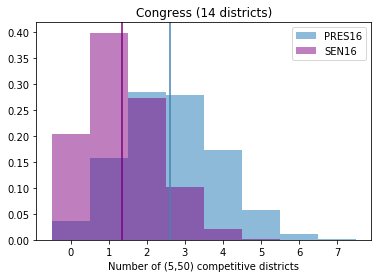

In [81]:
plt.title("Congress (14 districts)")
plt.xlabel("Number of (5,50) competitive districts")
plt.hist(competitive_seats("PRES16", cong),
         density=True, alpha=0.5, bins=np.arange(0,9)-0.5, label="PRES16")
plt.hist(competitive_seats("SEN16", cong), color="purple",
         density=True, alpha=0.5, bins=np.arange(0,9)-0.5, label="SEN16")
plt.axvline(x=competitive_seats_mean("PRES16", cong), color="steelblue")
plt.axvline(x=competitive_seats_mean("SEN16", cong), color="purple")
plt.legend()
plt.savefig("plots/competitiveness/num_compet_dists_congress.png",
            bbox_inches="tight", dpi=200)
plt.show()

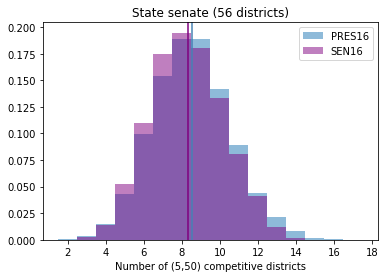

In [82]:
plt.title("State senate (56 districts)")
plt.xlabel("Number of (5,50) competitive districts")
plt.hist(competitive_seats("PRES16", sen),
         density=True, alpha=0.5, bins=np.arange(2,19)-0.5, label="PRES16")
plt.hist(competitive_seats("SEN16", sen), color="purple",
         density=True, alpha=0.5, bins=np.arange(2,19)-0.5, label="SEN16")
plt.axvline(x=competitive_seats_mean("PRES16", sen), color="steelblue")
plt.axvline(x=competitive_seats_mean("SEN16", sen), color="purple")
plt.legend()
plt.savefig("plots/competitiveness/num_compet_dists_state_senate.png",
           bbox_inches="tight", dpi=200)
plt.show()

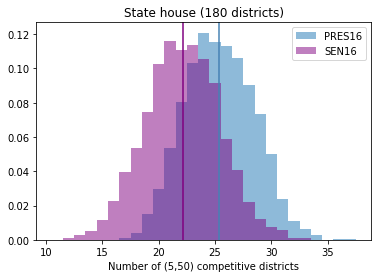

In [83]:
plt.title("State house (180 districts)")
plt.xlabel("Number of (5,50) competitive districts")
plt.hist(competitive_seats("PRES16", house),
         density=True, alpha=0.5, bins=np.arange(11,39)-0.5, label="PRES16")
plt.hist(competitive_seats("SEN16", house), color="purple",
         density=True, alpha=0.5, bins=np.arange(11,39)-0.5, label="SEN16")
plt.axvline(x=competitive_seats_mean("PRES16", house), color="steelblue")
plt.axvline(x=competitive_seats_mean("SEN16", house), color="purple")
plt.legend()
plt.savefig("plots/competitiveness/num_compet_dists_state_house.png",
           bbox_inches="tight", dpi=200)
plt.show()


## Trade-offs

In [39]:
cmap = plt.get_cmap("tab10")

### Congress

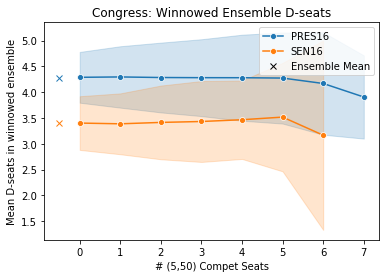

In [84]:
plt.title("Congress: Winnowed Ensemble D-seats")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean D-seats in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(cong["results_{}".format(e.lower())] > 0.45,
                                                 cong["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=cong["seats_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(cong["seats_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/congress_tradeoffs_D-seats.png",
            bbox_inches="tight", dpi=200)
plt.show()

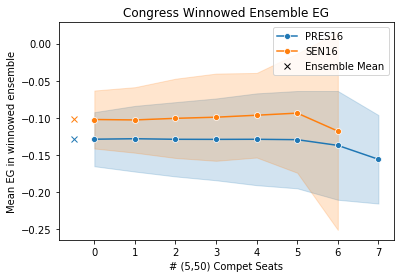

In [85]:
plt.title("Congress Winnowed Ensemble EG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean EG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(cong["results_{}".format(e.lower())] > 0.45,
                                                 cong["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=cong["efficiency_gap_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(cong["efficiency_gap_{}".format(e.lower())]), marker="x", c=cmap(i))
    
plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/congress_tradeoffs_eg.png",
            bbox_inches="tight", dpi=200)
plt.show()

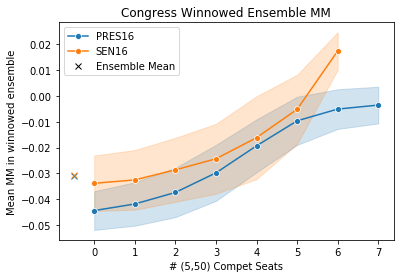

In [86]:
plt.title("Congress Winnowed Ensemble MM")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean MM in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(cong["results_{}".format(e.lower())] > 0.45,
                                                 cong["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=cong["mean_median_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(cong["mean_median_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()  
plt.savefig("plots/competitiveness/congress_tradeoffs_mm.png",
            bbox_inches="tight", dpi=200)
plt.show()

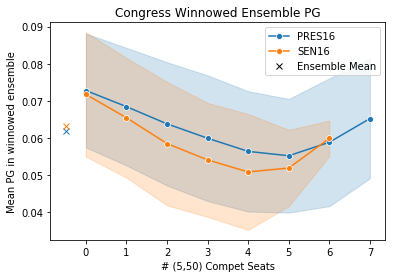

In [87]:
plt.title("Congress Winnowed Ensemble PG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean PG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(cong["results_{}".format(e.lower())] > 0.45,
                                                 cong["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=cong["partisan_gini_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(cong["partisan_gini_{}".format(e.lower())]), marker="x", c=cmap(i))
    
plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/congress_tradeoffs_pg.png",
            bbox_inches="tight", dpi=200)
plt.show()

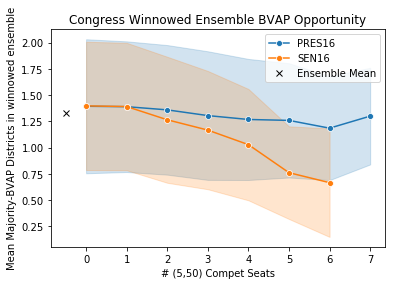

In [88]:
plt.title("Congress Winnowed Ensemble BVAP Opportunity")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean Majority-BVAP Districts in winnowed ensemble")

b = np.array(list(map(lambda x: sum(x > 0.5), cong["BVAP_perc"])))

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(cong["results_{}".format(e.lower())] > 0.45,
                                                 cong["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=b, marker='o', label=e, ci="sd")
    
plt.plot(-0.5, np.mean(b), marker="x", c="k", linestyle="None", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/congress_tradeoffs_bvap.png",
            bbox_inches="tight", dpi=200)
plt.show()

### State Senate

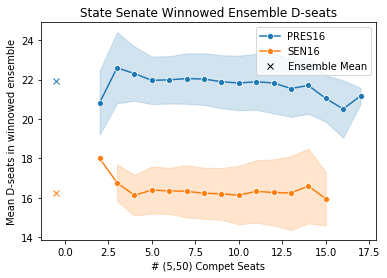

In [89]:
plt.title("State Senate Winnowed Ensemble D-seats")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean D-seats in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(sen["results_{}".format(e.lower())] > 0.45,
                                                 sen["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=sen["seats_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(sen["seats_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_senate_tradeoffs_D-seats.png",
            bbox_inches="tight", dpi=200)
plt.show()

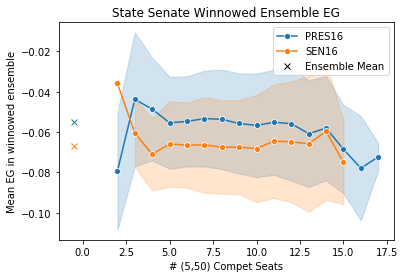

In [90]:
plt.title("State Senate Winnowed Ensemble EG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean EG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(sen["results_{}".format(e.lower())] > 0.45,
                                                 sen["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=sen["efficiency_gap_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(sen["efficiency_gap_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_senate_tradeoffs_eg.png",
            bbox_inches="tight", dpi=200)
plt.show()

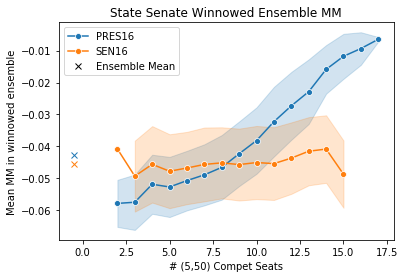

In [91]:
plt.title("State Senate Winnowed Ensemble MM")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean MM in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(sen["results_{}".format(e.lower())] > 0.45,
                                                 sen["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=sen["mean_median_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(sen["mean_median_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_senate_tradeoffs_mm.png",
            bbox_inches="tight", dpi=200)
plt.show()

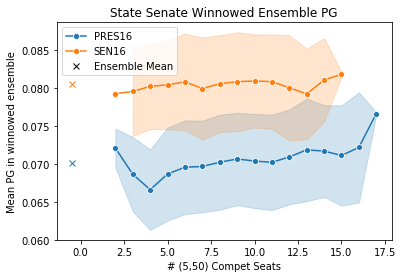

In [92]:
plt.title("State Senate Winnowed Ensemble PG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean PG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(sen["results_{}".format(e.lower())] > 0.45,
                                                 sen["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=sen["partisan_gini_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(sen["partisan_gini_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_senate_tradeoffs_pg.png",
            bbox_inches="tight", dpi=200)
plt.show()

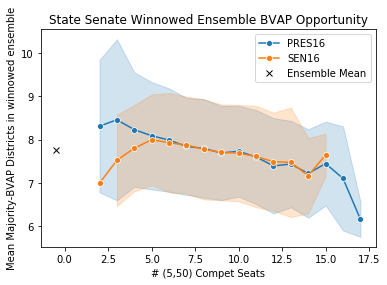

In [93]:
plt.title("State Senate Winnowed Ensemble BVAP Opportunity")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean Majority-BVAP Districts in winnowed ensemble")

b = np.array(list(map(lambda x: sum(x > 0.5), sen["BVAP_perc"])))

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(sen["results_{}".format(e.lower())] > 0.45,
                                                 sen["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=b, marker='o', label=e, ci="sd")

plt.plot(-0.5, np.mean(b), marker="x", c="k", linestyle="None", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_senate_tradeoffs_bvap.png",
            bbox_inches="tight", dpi=200)
plt.show()

### State House

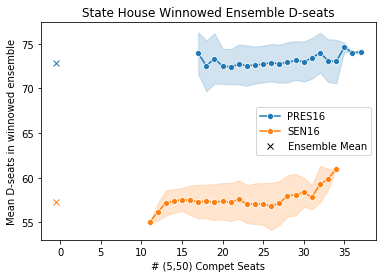

In [94]:
plt.title("State House Winnowed Ensemble D-seats")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean D-seats in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(house["results_{}".format(e.lower())] > 0.45,
                                                 house["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=house["seats_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(house["seats_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_house_tradeoffs_D-seats.png",
            bbox_inches="tight", dpi=200)
plt.show()

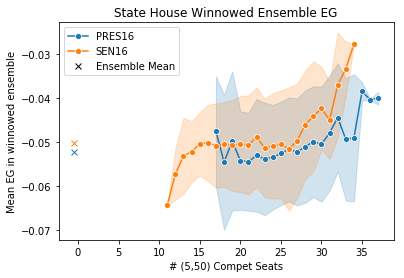

In [95]:
plt.title("State House Winnowed Ensemble EG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean EG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(house["results_{}".format(e.lower())] > 0.45,
                                                 house["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=house["efficiency_gap_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(house["efficiency_gap_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_house_tradeoffs_eg.png",
            bbox_inches="tight", dpi=200)
plt.show()

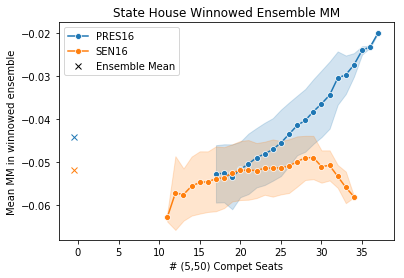

In [96]:
plt.title("State House Winnowed Ensemble MM")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean MM in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(house["results_{}".format(e.lower())] > 0.45,
                                                 house["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=house["mean_median_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(house["mean_median_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_house_tradeoffs_mm.png",
            bbox_inches="tight", dpi=200)
plt.show()

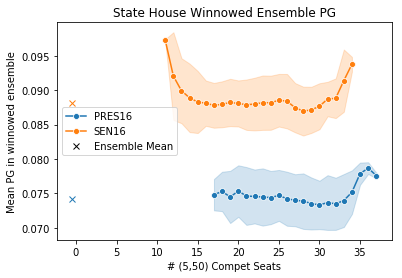

In [97]:
plt.title("State House Winnowed Ensemble PG")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean PG in winnowed ensemble")

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(house["results_{}".format(e.lower())] > 0.45,
                                                 house["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=house["partisan_gini_{}".format(e.lower())], marker='o', label=e, ci="sd")
    plt.plot(-0.5, np.mean(house["partisan_gini_{}".format(e.lower())]), marker="x", c=cmap(i))

plt.plot([],linestyle="None", marker="x", color="k", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_house_tradeoffs_pg.png",
            bbox_inches="tight", dpi=200)
plt.show()

In [ ]:
plt.title("State House Winnowed Ensemble BVAP Opportunity")
plt.xlabel("# (5,50) Compet Seats")
plt.ylabel("Mean Majority-BVAP Districts in winnowed ensemble")

b = np.array(list(map(lambda x: sum(x > 0.5), house["BVAP_perc"])))

for i, e in enumerate(elections):
    c = np.array(list(map(np.sum, np.logical_and(house["results_{}".format(e.lower())] > 0.45,
                                                 house["results_{}".format(e.lower())] < 0.55))))
    sns.lineplot(x=c, y=b, marker='o', label=e, ci="sd")

plt.plot(-0.5, np.mean(b), marker="x", c="k", linestyle="None", label="Ensemble Mean")
plt.legend()
plt.savefig("plots/competitiveness/state_house_tradeoffs_bvap.png",
            bbox_inches="tight", dpi=200)
plt.show()